# CSCK506 - Deep Learning

## Import libraries


In [ ]:
from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import keras
import tensorflow as tf

from keras.utils.vis_utils import plot_model

# from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix


import cv2
import os

## Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Import, visualize and manipuplate Data

### Define some initial parameters

In [ ]:
data_dir = '/content/drive/MyDrive/MSc_Liverpool_University_AI/CSCK506/week08/group_activity/dataset/chest_xray/'
train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')
val_data_dir = os.path.join(data_dir, 'val')

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

In [ ]:
def get_data(data_dir, labels, img_size):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

### Get the train, test and validation data using 'get_data'

In [ ]:
train_set = get_data(train_data_dir, labels, img_size)
test_set = get_data(test_data_dir, labels, img_size)
val_set = get_data(val_data_dir, labels, img_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


### Split the datasets into x and y (independent and dependent variables, respectively)

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train_set:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_set:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val_set:
    x_val.append(feature)
    y_val.append(label)

### Visualize the data

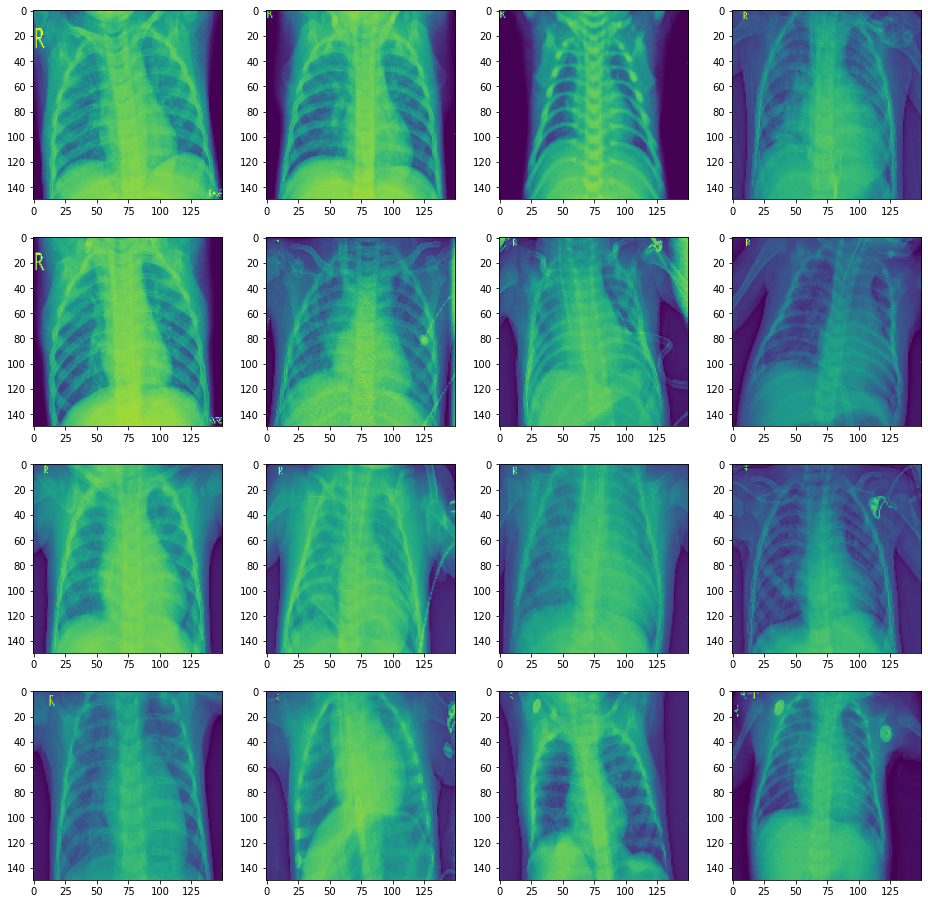

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(16,16))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_train[i])

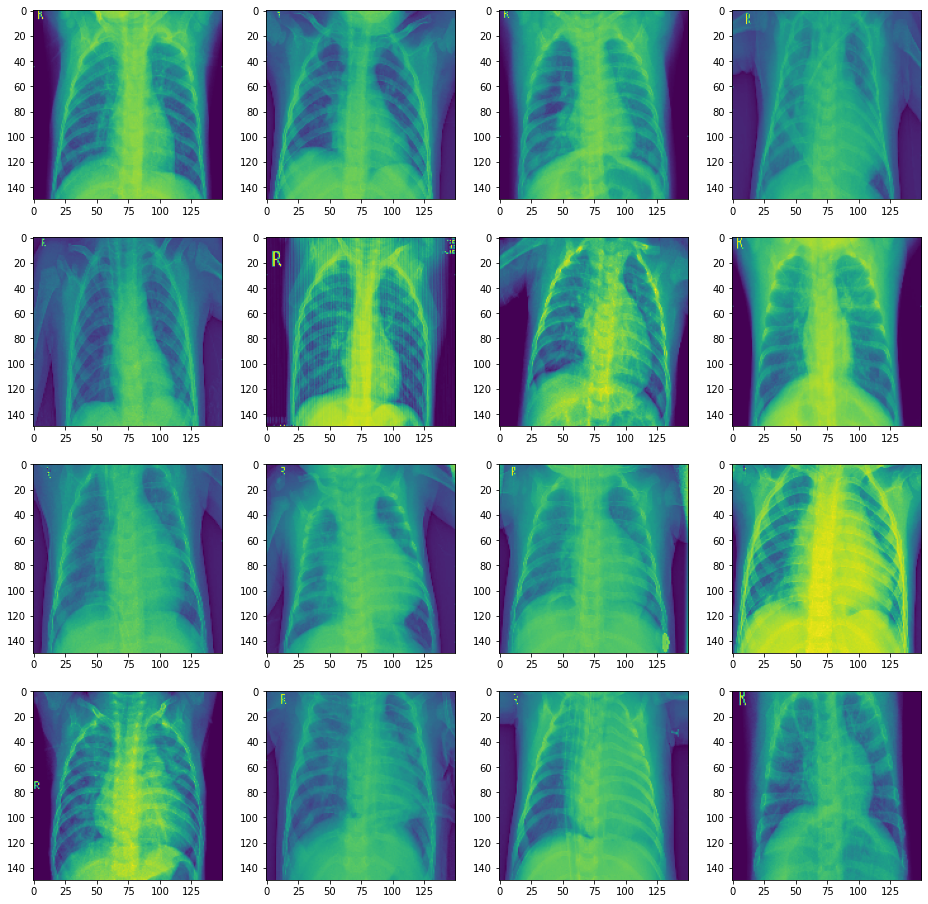

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(16,16))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test[i])

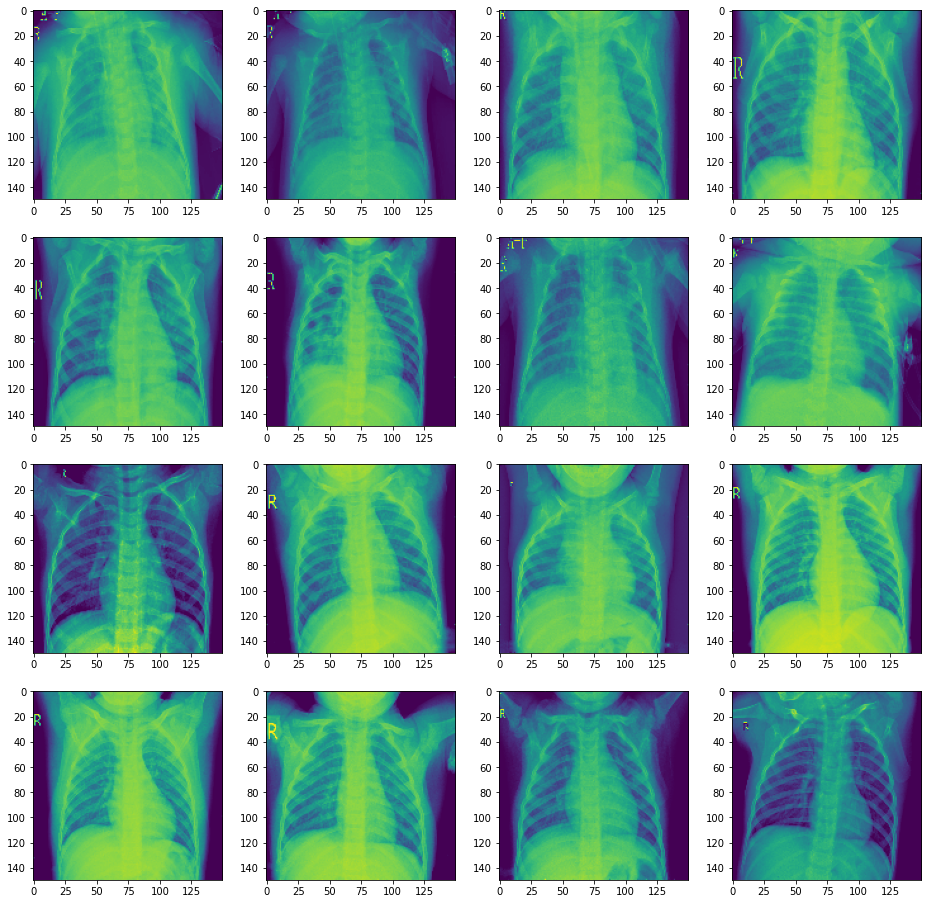

In [ ]:
fig, axes = plt.subplots(4,4, figsize=(16,16))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_val[i])

### Normalize the data

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

### Resize the data

In [ ]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## Model

### Build the model

In [ ]:
def H(inputs, num_filters, dropout_rate):
    x = tf.keras.layers.BatchNormalization(epsilon=eps)(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.ZeroPadding2D((1, 1))(x)
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), use_bias=False, kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate )(x)
    return x

In [ ]:
def transition(inputs, num_filters, compression_factor, dropout_rate):
    x = tf.keras.layers.BatchNormalization(epsilon=eps)(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    num_feature_maps = inputs.shape[1]

    x = tf.keras.layers.Conv2D(np.floor(compression_factor * num_feature_maps).astype(np.int),
                               kernel_size=(1, 1), use_bias=False, padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2( 1e-4 ))(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
    return x

In [ ]:
def dense_block(inputs, num_layers, num_filters, growth_rate , dropout_rate):
    for i in range(num_layers):
        conv_outputs = H(inputs, num_filters, dropout_rate)
        inputs = tf.keras.layers.Concatenate()([conv_outputs, inputs])
        num_filters += growth_rate
    return inputs, num_filters

In [ ]:
input_shape = (img_size, img_size, 1) 
num_blocks = 3
num_layers_per_block = 4
growth_rate = 16
dropout_rate = 0.4
compress_factor = 0.5
eps = 1.1e-5

num_filters = 16

In [ ]:
inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, 3), use_bias=False, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)

for i in range(num_blocks):
    x, num_filters = dense_block(x, num_layers_per_block, num_filters, growth_rate, dropout_rate)
    x = transition(x, num_filters, compress_factor, dropout_rate )

x = tf.keras.layers.GlobalAveragePooling2D()(x) 
x = tf.keras.layers.Dense(1)(x)
outputs = tf.keras.layers.Activation('sigmoid')(x)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
model = tf.keras.models.Model(inputs, outputs)

### Display the model

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 148, 148, 16  144         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 148, 148, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

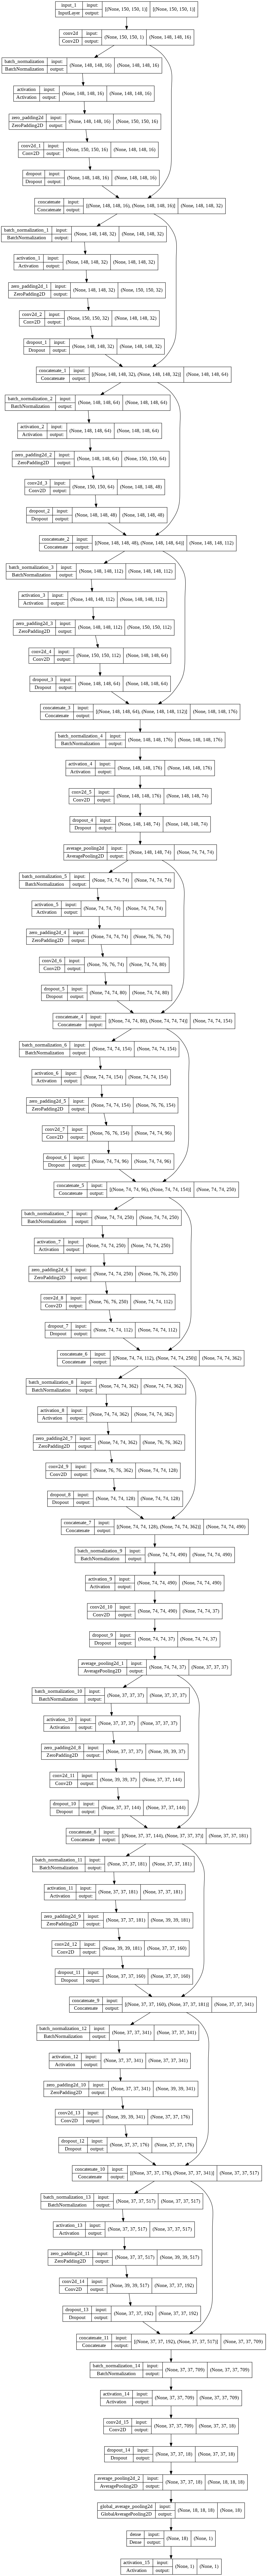

In [ ]:
plot_model(model, to_file='densenet.png', show_shapes=True, show_layer_names=True)

### Export the model

In [ ]:
model.save('/content/drive/MyDrive/MSc_Liverpool_University_AI/CSCK506/week08/group_activity/models/densenet.h5')

### Compile the model

In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

### Train the model

In [ ]:
batch_size = 32
epochs = 10

In [ ]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/10
164/164 [==============================] - 138s 713ms/step - loss: 0.3333 - accuracy: 0.8619 - val_loss: 7.0953 - val_accuracy: 0.5000
Epoch 2/10
164/164 [==============================] - 111s 679ms/step - loss: 0.2456 - accuracy: 0.9132 - val_loss: 7.4426 - val_accuracy: 0.5000
Epoch 3/10
164/164 [==============================] - 114s 693ms/step - loss: 0.2231 - accuracy: 0.9233 - val_loss: 3.8878 - val_accuracy: 0.5000
Epoch 4/10
164/164 [==============================] - 115s 699ms/step - loss: 0.1933 - accuracy: 0.9389 - val_loss: 5.0810 - val_accuracy: 0.5000
Epoch 5/10
164/164 [==============================] - 115s 702ms/step - loss: 0.1775 - accuracy: 0.9414 - val_loss: 3.5492 - val_accuracy: 0.5000
Epoch 6/10
164/164 [==============================] - 116s 706ms/step - loss: 0.1676 - accuracy: 0.9489 - val_loss: 4.2900 - val_accuracy: 0.5000
Epoch 7/10
164/164 [==============================] - 116s 705ms/step - loss: 0.1553 - accuracy: 0.9550 - val_loss: 3.0437 -

## Results Analysis

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 4s 179ms/step - loss: 1.4236 - accuracy: 0.6651
Loss of the model is -  1.4236013889312744
20/20 [==============================] - 4s 179ms/step - loss: 1.4236 - accuracy: 0.6651
Accuracy of the model is -  66.50640964508057 %


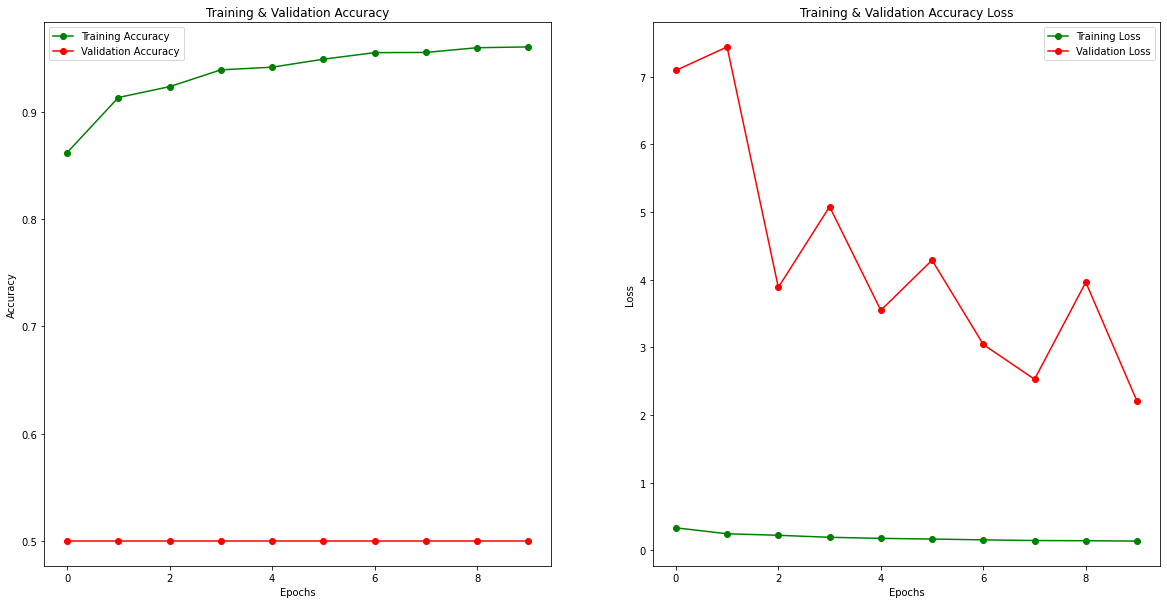

In [ ]:
epochs_range = [i for i in range(epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs_range , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs_range , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs_range , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs_range , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Accuracy Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
predictions = np.round_(model.predict(x_test))
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.65      1.00      0.79       390
   Normal (Class 1)       1.00      0.11      0.19       234

           accuracy                           0.67       624
          macro avg       0.83      0.55      0.49       624
       weighted avg       0.78      0.67      0.57       624



In [ ]:
confusion_matrix(y_test,predictions)

array([[390,   0],
       [209,  25]])